The late afternoon wind speeds (between 15 and 18 LMST) seem to have an issue. Moderate wind speeds (between about 5 and 7 m/s) are dropped somehow, and only smaller or larger wind speeds are recorded. Unfortunately, for my wind profile experiments, this gap in the data is basically fatal. So instead of trying to use the data directly, I'm going to try to replicate the red noise structure and generate synthetic data. This notebook attempts to do that analysis.

In [30]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from numpy.random import normal, uniform
from scipy.stats import median_abs_deviation as mad
from scipy.signal import medfilt

from astropy.convolution import convolve, Box1DKernel

# https://docs.astropy.org/en/stable/timeseries/lombscargle.html
from astropy.timeseries import LombScargle

from local_utils import *

def generate_synthetic_wind(sampling=)
    sampling = time_array[1] - time_array[0]
    corr_time = 30. # 30 seconds
    num_points = int(np.floor(corr_time/sampling))

    # Boxcar filter to inject red noise
    synthetic_wind = np.median(wind) +\
        convolve(normal(size=len(time)), Box1DKernel(num_points))*np.sqrt(2.)*(np.max(wind) - np.min(wind))
    # Be sure to remove negative values
    synthetic_wind -= np.min(synthetic_wind)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Processing label: ./MEDA_WS_Data/WE__0133___________DER_WS__________________P02.xml
Now processing a Header structure: HEADER
Now processing a Table_Delimited structure: TABLE


Text(0, 0.5, '$U\\ \\left( {\\rm cm\\ s^{-1}} \\right)$')

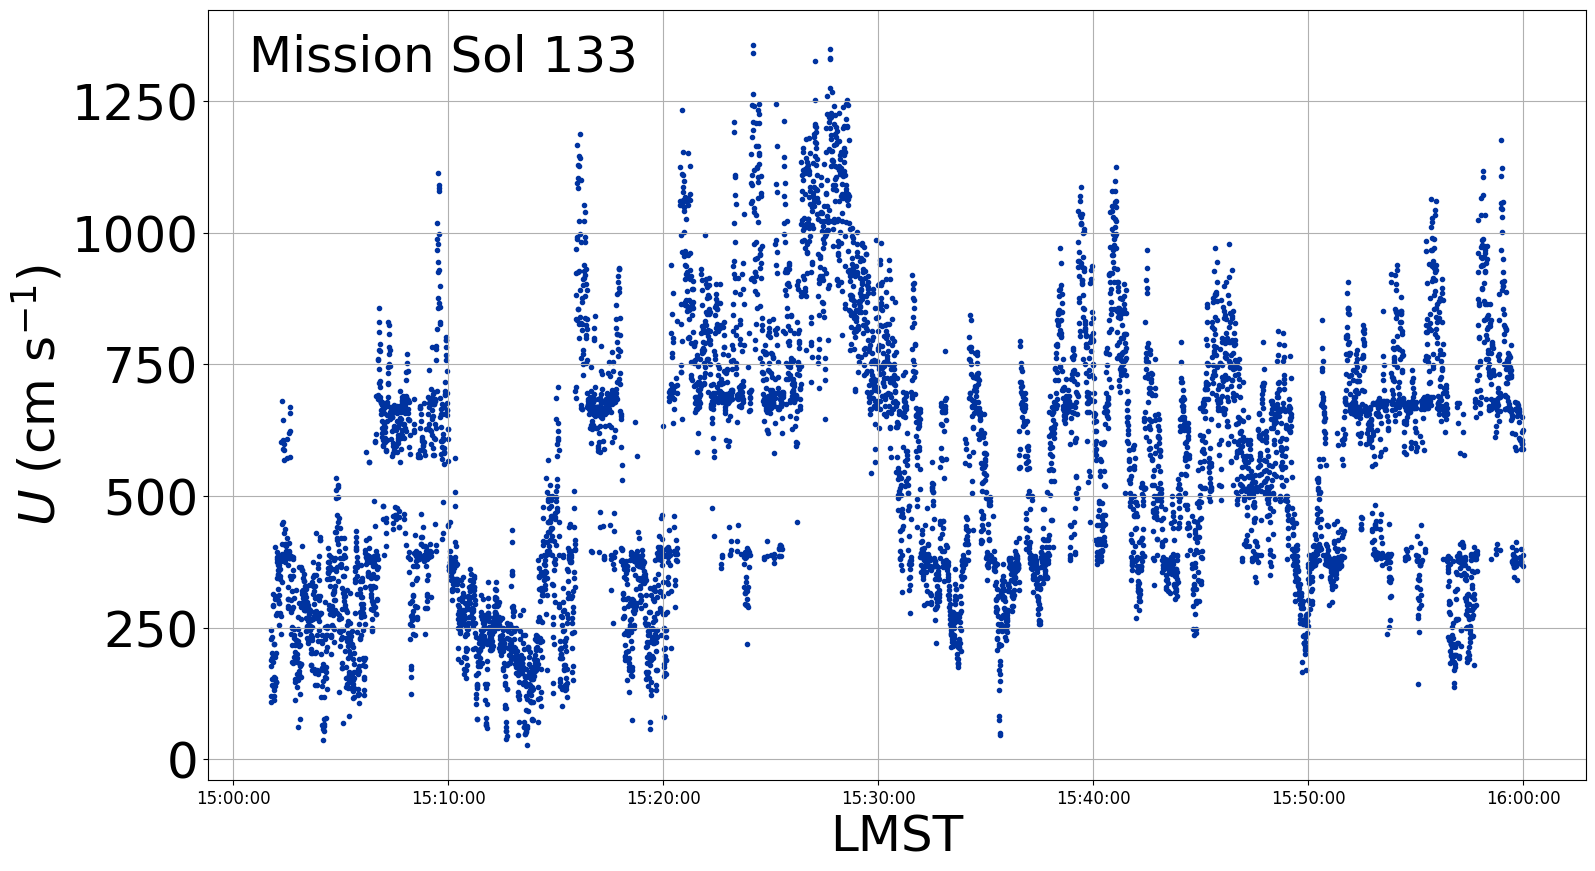

In [3]:
# WS_file = '/Users/brian/Documents/research/Active Projects/Measuring_Wind_with_Ingenuity/code/WE__0133___________DER_WS__________________P01.xml'
which_sol = "0133"
path = './MEDA_WS_Data/'
WS_file = path + 'WE__%s___________DER_WS__________________P02.xml' % (which_sol)

time, wind = retrieve_time_wind(WS_file, start_time=datetime(1900, 1, 1, 15, 0, 0), end_time=datetime(1900, 1, 1, 16, 0, 0))
# time, wind = retrieve_time_wind(WS_file, start_time=None, end_time=None)
wind *= 100. # Convert to cm/s

fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax = fig.add_subplot(111)

ax.scatter(time, wind, marker='.', color=BoiseState_blue)

ax.text(0.03, 0.92, "Mission Sol 133", transform=ax.transAxes, fontsize=36)
xfmt = md.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
ax.grid(True)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=36)
ax.set_xlabel("LMST", fontsize=36)
ax.set_ylabel(r'$U\ \left( {\rm cm\ s^{-1}} \right)$', fontsize=36)
# ax.set_xlim([datetime(1900, 1, 1, 15, 0, 0), datetime(1900, 1, 1, 15, 10, 0)])

[141529.96533333   3757.43270796   3567.98231933   1854.10434934
   1806.76551489]


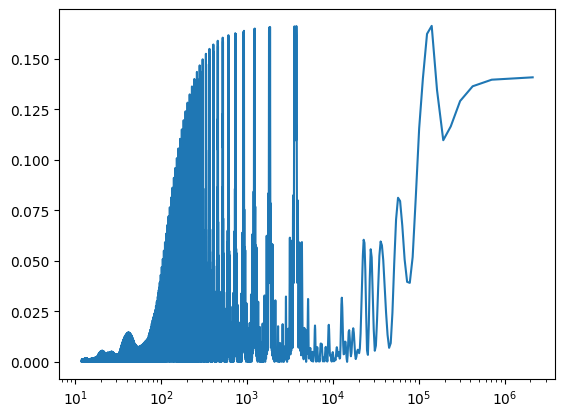

In [7]:
time_array = np.array([time[i].minute*60*60 + time[i].minute*60 + time[i].second + time[i].microsecond/1e6
                       for i in range(len(time))])
time_array -= np.min(time_array)
frequency, power = LombScargle(time_array, wind).autopower()
plt.semilogx(1./frequency, power)

srt_ind = np.argsort(power)[::-1]
print(1./frequency[srt_ind][0:5])

(-25566.375, -25566.368055555555)

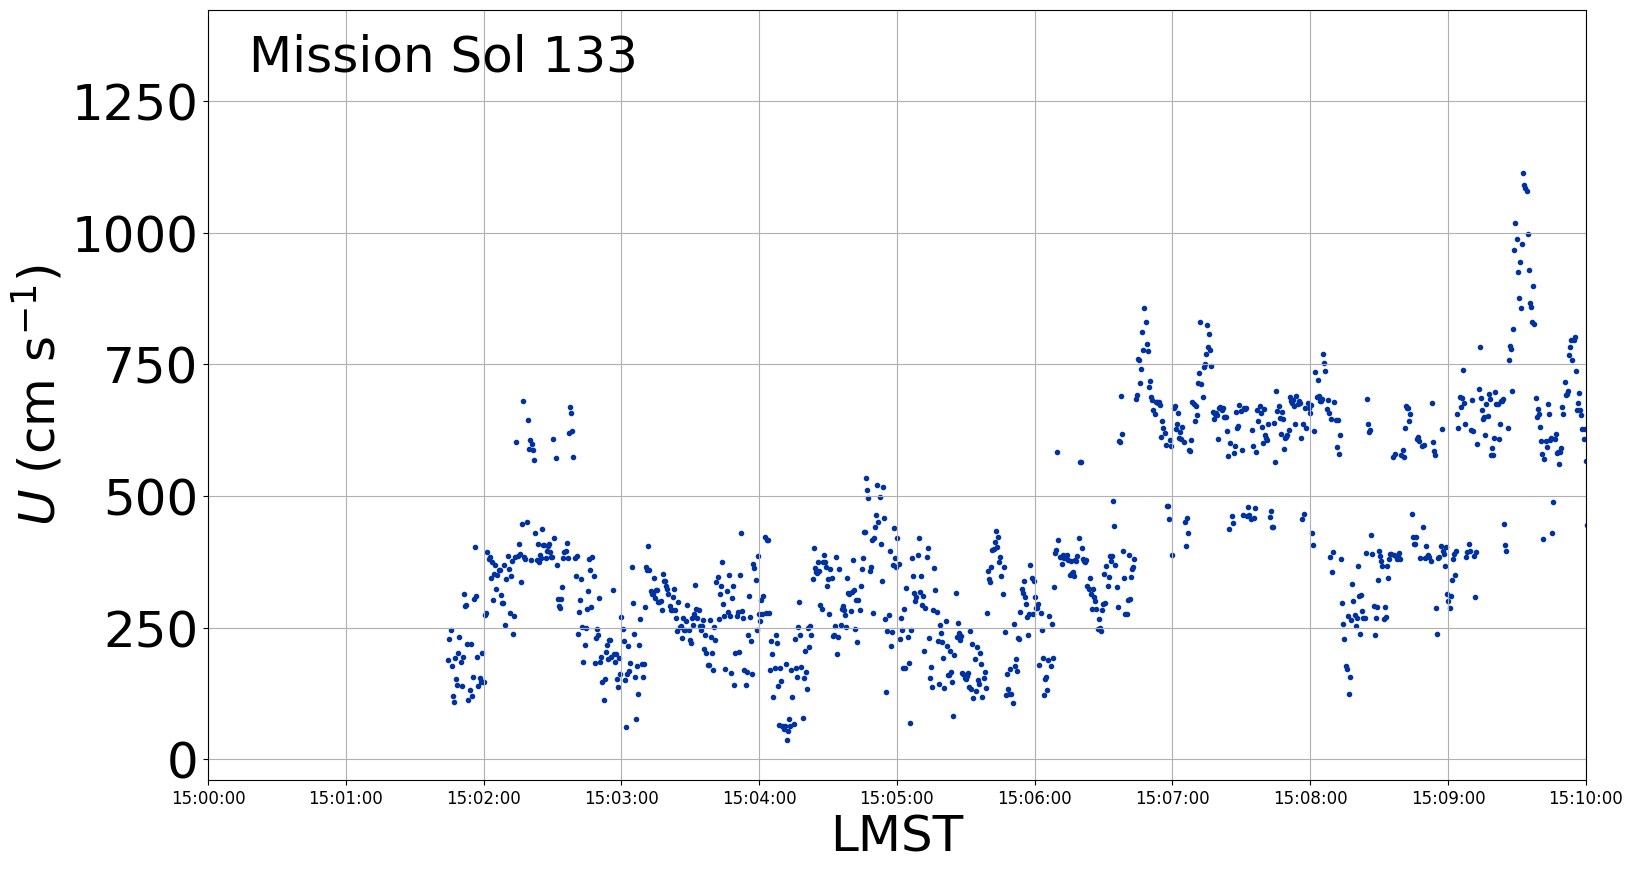

In [5]:
fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax = fig.add_subplot(111)

ax.scatter(time, wind, marker='.', color=BoiseState_blue)

ax.text(0.03, 0.92, "Mission Sol 133", transform=ax.transAxes, fontsize=36)
xfmt = md.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
ax.grid(True)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=36)
ax.set_xlabel("LMST", fontsize=36)
ax.set_ylabel(r'$U\ \left( {\rm cm\ s^{-1}} \right)$', fontsize=36)
ax.set_xlim([datetime(1900, 1, 1, 15, 0, 0), datetime(1900, 1, 1, 15, 10, 0)])

# Sure looks to me like there's a correlation timescale of about 1 minute

0.48700000000008004


Text(0, 0.5, 'Synth $U\\ \\left( {\\rm cm\\ s^{-1}} \\right)$')

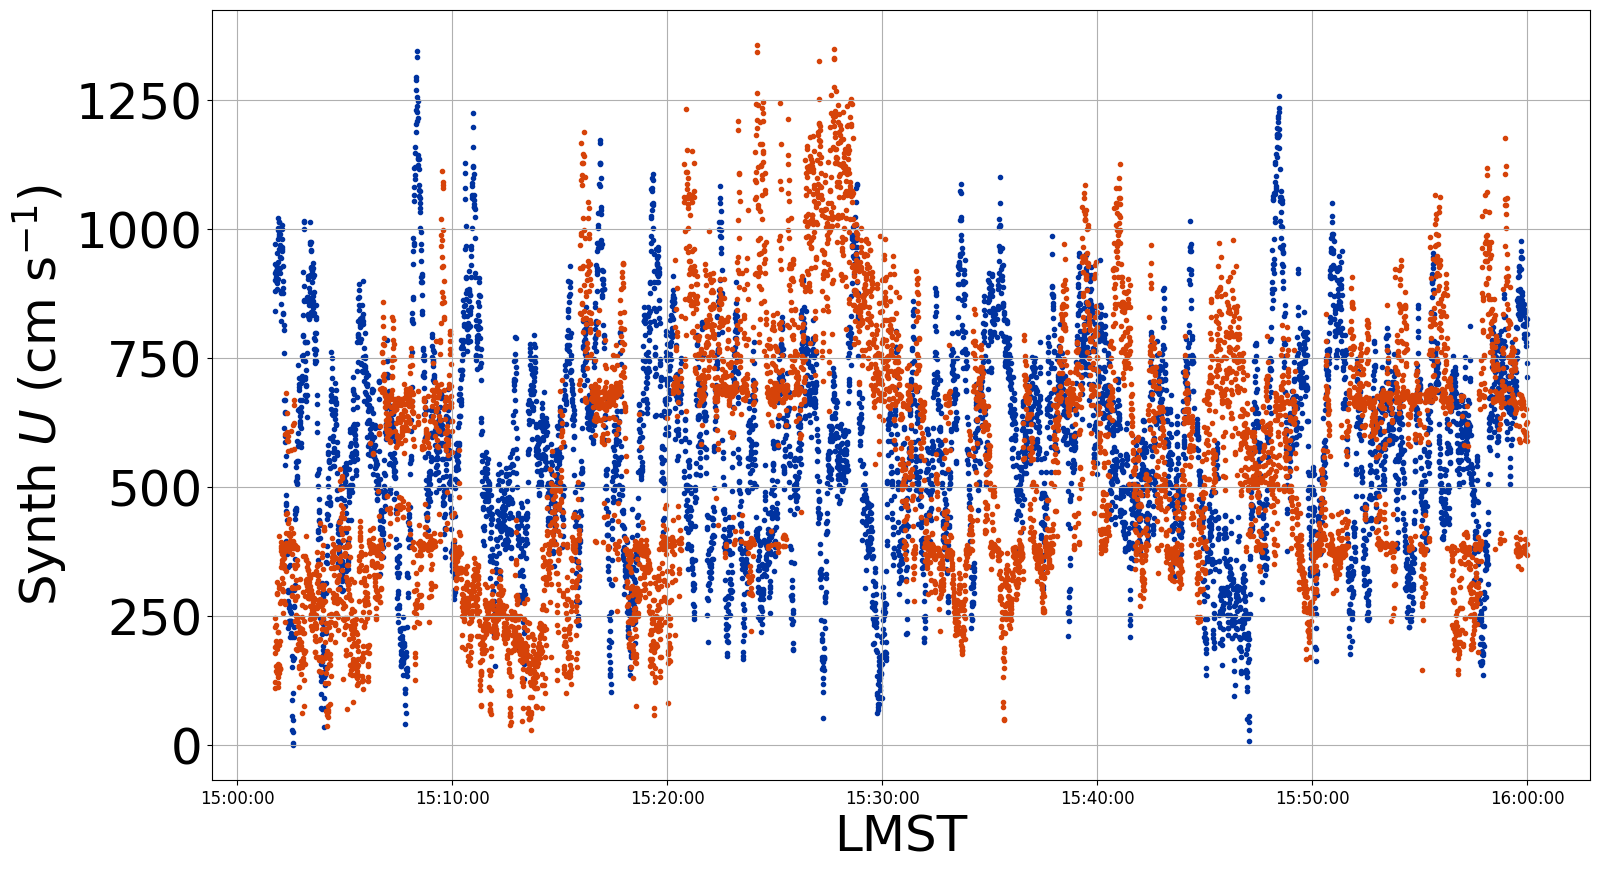

In [58]:
fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax = fig.add_subplot(111)

sampling = time_array[1] - time_array[0]
print(sampling)
corr_time = 30. # 30 seconds
num_points = int(np.floor(corr_time/sampling))

# Boxcar filter to inject red noise
synthetic_wind = np.median(wind) +\
    convolve(normal(size=len(time)), Box1DKernel(num_points))*np.sqrt(2.)*(np.max(wind) - np.min(wind))
# Be sure to remove negative values
synthetic_wind -= np.min(synthetic_wind)

# synthetic_wind = uniform(size=len(time), low=np.min(wind), high=np.max(wind))
# synthetic_wind = np.median(wind) + medfilt(normal(size=len(time), scale=mad(wind)), kernel_size=num_points)

ax.scatter(time, synthetic_wind, marker='.', color=BoiseState_blue)
ax.scatter(time, wind, marker='.', color=BoiseState_orange)
xfmt = md.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
ax.grid(True)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=36)
ax.set_xlabel("LMST", fontsize=36)
ax.set_ylabel(r'Synth $U\ \left( {\rm cm\ s^{-1}} \right)$', fontsize=36)

(-25566.373788773148, -25566.372399884258)

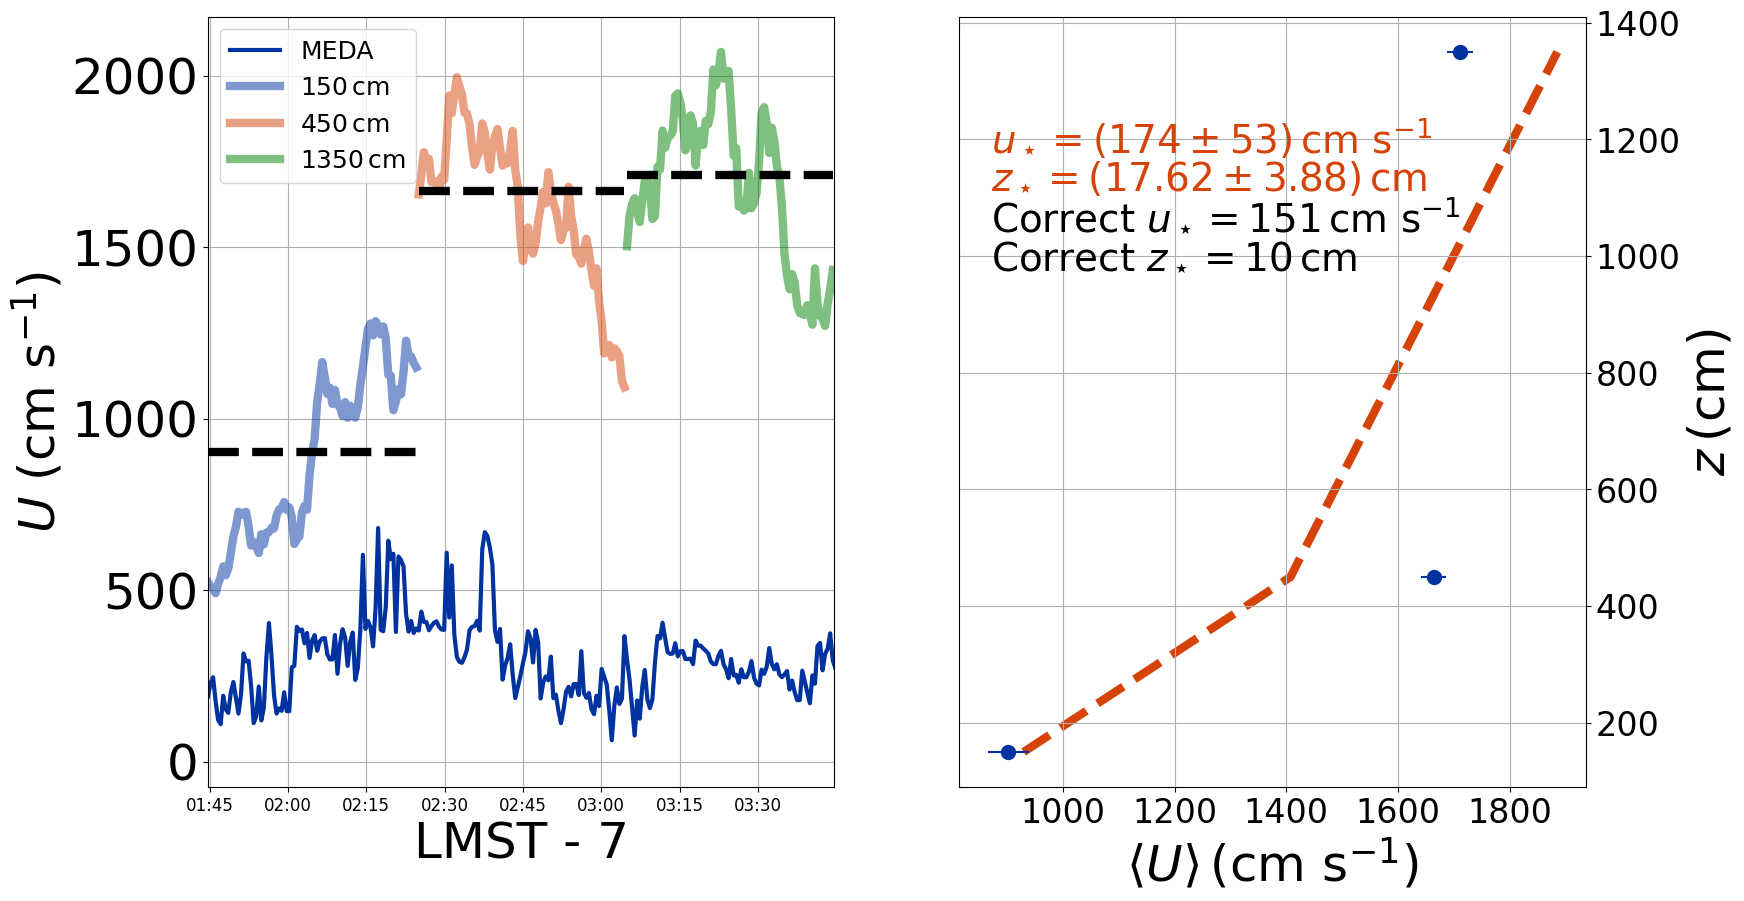

In [57]:
fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

saved_zstar = 10. # cm
t0 = np.min(time)
ind = retrieve_relevant_times(time, t0, len(zs)*sample_time)
saved_ustar = kappa*np.median(synthetic_wind[ind])/np.log(zs[0]/saved_zstar)

scaled_windspeeds = create_synthetic_wind_profile(synthetic_wind, zs, saved_zstar, z0=np.min(zs))
t0 = np.min(time)
averaged_windspeeds, std_windspeeds = sample_wind_profile(sample_time, t0, time, scaled_windspeeds, zs)
ax1 = make_plot_of_original_and_scaled_windspeeds(time, wind, zs, sample_time, t0, scaled_windspeeds, 
                                                  averaged_windspeeds, ax1)

u_star, z_star, sigma_u_star, sigma_z_star, std_windspeeds =\
    fit_wind_profile_scaled_values(zs, averaged_windspeeds, std_windspeeds, rescale_unc=False)

ax2 = make_plot_of_wind_data_and_profile_scaled_values(zs, averaged_windspeeds, 
    std_windspeeds, u_star, z_star, sigma_u_star, sigma_z_star, ax2)

ax2.text(0.05, 0.725, r'Correct $u_\star = %.0f\, {\rm cm\ s^{-1}}$' % (saved_ustar), 
         fontsize=28, transform=ax2.transAxes)
ax2.text(0.05, 0.675, r'Correct $z_\star = %.0f\, {\rm cm}$' % (saved_zstar), 
         fontsize=28, transform=ax2.transAxes)
ax1.set_xlim([np.min(time), np.min(time) + timedelta(seconds=len(zs)*sampling_duration)])